# Reading the ROOT files

In [ ]:
def load_obj(name, directory='./'):
    with open(directory + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
core_rates = load_obj('core_rates', directory='./data/')
acceptances = load_obj('rates')

In [651]:
import networkx as nx
import torch
from tqdm import tqdm

from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, ASAPooling
from torch.nn import Linear, Sequential, ReLU, Dropout, Sigmoid

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [652]:
# exec(open("./do_imports.py").read())

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [653]:
from evaluate_results import *
from batched_data import *
import cnn_batched_data

In [654]:
import uproot
import numpy as np
import pandas as pd

In [655]:
def get_input_gcn(data, batch_size=16):
    dat = data[0]
    y = data[1]
    charge = np.zeros((batch_size, 2330))
    for i in range(batch_size):
        charge[i, dat.channel[i]]= charge[i, dat.channel[i]] + dat.pmtcharge[i]
    charge = np.reshape( charge, (len( charge ), 2330,1) )
    x = np.concatenate( (charge, pos_iter), axis=-1).astype(np.float32)
    
    return x, y

In [42]:
val = cnn_batched_data.PNSequence('pn_test', batch_size=64, shuffle=False)
train = cnn_batched_data.PNSequence('pn_train', batch_size=64, shuffle=False)


In [656]:
val = GCN_utils.GCNSeq('pn_test', batch_size=64, shuffle=False)


NameError: name 'GCN_utils' is not defined

In [9]:
data = val.x

In [8]:
def get_positions(event):
    pmts = event.channel
    xpos = x[pmts]
    ypos = y[pmts]
    zpos = z[pmts] 
    
    return xpos, ypos, zpos
def plot_histo(pos):
    x, y, z = pos
    
    r = np.sqrt(x**2+y**2)
    plt.scatter(pmtr*np.arctan2(pmty, pmtx), pmtz*570/pmtr, alpha=0.1)
    plt.hist2d(r*np.arctan2(y, x), z*570/r, bins=50, range=[[-2000,2000], [-2000,2000]],cmin=1, cmap=plt.cm.plasma)
    
#     plt.colorbar()

In [9]:
dist = np.zeros((2330, 2330))
for i, pmtpos in enumerate(whatis):
    dist[i] = np.sqrt(np.sum((whatis - whatis[i])**2, axis=1))
all_edges = np.argwhere(dist<500)
G = nx.Graph()
G.add_edges_from(all_edges)
torch_graph = from_networkx(G)
torch_graph.pos = whatis

In [99]:
nx.write_gpickle(G, 'data/graph1.pkl',)

In [104]:
def get_graph(max_dist=500, loadpath=None):
    if loadpath is not None: 
        G = nx.read_gpickle(loadpath)
        torch_graph = from_networkx(G)
        torch_graph.pos = pmtxyz
        return torch_graph
    
    dist = np.zeros((2330, 2330))
    for i, pmtpos in enumerate(pmtxyz):
        dist[i] = np.sqrt(np.sum((pmtxyz - pmtxyz[i])**2, axis=1))
    all_edges = np.argwhere(dist<500)
    G = nx.Graph()
    G.add_edges_from(all_edges)
    torch_graph = from_networkx(G)
    torch_graph.pos = pmtxyz
    return torch_graph 


In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(dist, interpolation='none', cmap=plt.get_cmap("temperature_r"))
plt.title('Euclidian Distance Between PMTs (WbLS)', fontsize=18)
plt.xlabel('PMT Index', fontsize=16)
plt.ylabel('PMT Index', fontsize=16)
plt.colorbar(label='Distance (cm)', )
plt.tick_params(axis='both', labelsize=12)
plt.show()

In [166]:
dat = datagen.__getitem__(0)

In [21]:
final_out = 16
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(final_out*2330, 16),
                              ReLU(),
                              Linear(16, 2), 
#                               ReLU(),
#                               Linear(16, 1), 
                              Sigmoid()
                             )
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, final_out)
#         self.pool1 = ASAPooling(28)
#         self.conv3 = GCNConv(512, 256)
#         self.conv4 = GCNConv(256, 64)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = x.view(-1, final_out*2330)
        return self.lin(x)

In [97]:
class Net(torch.nn.Module):
    def __init__(self, final_out=16):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(final_out*2330, 16),
                              ReLU(),
                              Linear(16, 1), 
                              Sigmoid()
                             )

        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, final_out)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = x.view(-1, final_out*2330)
        return self.lin(x)

In [22]:
model = Net()

In [84]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [88]:
datagen = GCNSeq('pn_train')


In [160]:
def gnn_model_summary(model):
    
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)
gnn_model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
        lin.0.weight                [16, 37280]          596480
          lin.0.bias                       [16]              16
        lin.2.weight                    [1, 16]              16
          lin.2.bias                        [1]               1
        conv1.weight                    [4, 16]              64
          conv1.bias                       [16]              16
        conv2.weight                   [16, 16]             256
          conv2.bias                       [16]              16
----------------------------------------------------------------
Total params: 596865
Trainable params: 596865
Non-trainable params: 0


In [239]:
G = nx.read_gpickle('data/graph1.pkl')
torch_graph = from_networkx(G)

In [ ]:
plt.figure(figsize=(20, 15))
nx.draw_networkx(G, node_size=20, with_labels=False, width=.3, edge_color='k', alpha=0.3)
plt.show()

In [448]:
torch_graph.edge_index.shape

torch.Size([2, 770888])

In [546]:
max_dist=200
all_edges = np.argwhere(dist<max_dist)
all_weights = 1. - dist/np.max(dist)
loops = np.argwhere(dist==0)

In [567]:
# sel_weights = np.expand_dims(all_weights[np.where(dist<max_dist)], axis=1)
sel_weights = all_weights[np.where(dist<max_dist)]
edges_and_weights = np.hstack((all_edges, sel_weights))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [587]:
sel_weights = all_weights[np.logical_and(dist!=0, dist<max_dist)]
all_edges = np.argwhere(np.logical_and(dist!=0, dist<max_dist))


In [548]:
GG = nx.Graph()

In [549]:
%%time
GG.add_weighted_edges_from(edges_and_weights)
# GG.remove_edges_from(loops)

CPU times: user 463 ms, sys: 11.8 ms, total: 475 ms
Wall time: 473 ms


In [592]:
torch_graph.edge_index = torch.tensor(sel_weights, dtype=torch.double)

In [594]:
torch.double

torch.float64

In [593]:
torch_graph.edge_index

tensor([0.9684, 0.9684, 0.9554,  ..., 0.9047, 0.9364, 0.9682],
       dtype=torch.float64)

In [551]:
%%time 
torch_graph = from_networkx(GG)

CPU times: user 24.7 s, sys: 37 ms, total: 24.8 s
Wall time: 24.8 s


In [ ]:
all_weights[all_edges]

In [451]:
weights = 1. - dist/np.max(dist)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(weights,interpolation=None, cmap=plt.cm.plasma)
plt.title('Edges (Dependencies) between PMTs')
plt.colorbar()
# plt.colorbar()
plt.show()

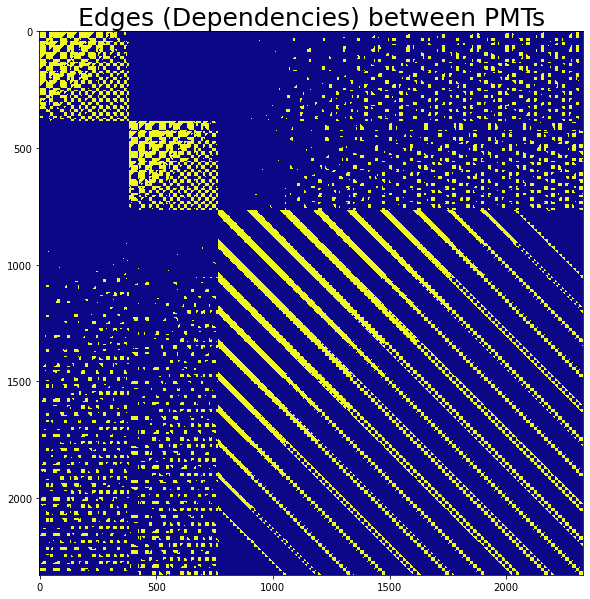

In [650]:
plt.figure(figsize=(10,10))
plt.imshow(edges,interpolation='none', cmap=plt.cm.plasma)
plt.title('Edges (Dependencies) between PMTs', fontsize=25)
# plt.colorbar()
plt.show()

We want where quicknext<500 us (so another prompt follows) and the subid==1. 

In [365]:
def get_graph(max_dist=500, loadpath=None, return_nx=False):
    if loadpath is not None: 
        G = nx.read_gpickle(loadpath)
        torch_graph = from_networkx(G)
        torch_graph.pos = pmtxyz
        return torch_graph
    
    dist = np.zeros((2330, 2330))
    for i, pmtpos in enumerate(pmtxyz):
        dist[i] = np.sqrt(np.sum((pmtxyz - pmtxyz[i])**2, axis=1))
    all_edges = np.argwhere(dist<max_dist)
    loops = np.argwhere(dist==0)
    G = nx.Graph()
    G.add_edges_from(all_edges)
    G.remove_edges_from(loops)
    torch_graph = from_networkx(G)
    torch_graph.pos = pmtxyz
    if return_nx: return G
    return torch_graph 


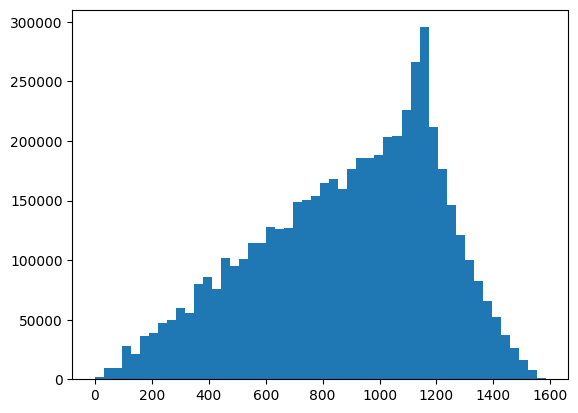

In [607]:
plt.hist(np.ravel(dist), bins=50)
plt.show()

In [383]:
G2 = get_graph(max_dist=100, return_nx=True)

In [331]:
nx.draw(G2)
plt.show()

In [345]:
pos = nx.spring_layout(G2)

In [626]:
pos2 = nx.drawing.spring_layout(G2, dim=2)

In [412]:
pos3 = pmtxyz[:,:2]

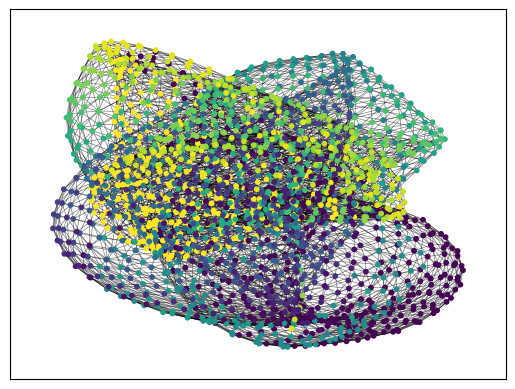

In [628]:
# plt.axes(projection='3d')
nx.draw_networkx_edges(G2, pos=pos2, width=0.5, alpha=0.5,)
nx.draw_networkx_nodes(G2, pos=pos2, node_size=10, node_color=pmtz)
# plt.xlim(-0.3, 0.3)
# plt.ylim(-0.3, 0.3)
plt.show()

In [635]:
%matplotlib inline

## Make gif visualizations of hits in time 